In [3]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle as pkl
#import imageio
#from PIL import Image, ImageEnhance
from tqdm.notebook import tqdm
%matplotlib inline

This notebook contains analysis of segmentation areas, which will be used in rate constants determination

In [8]:
dirpath = '../data/kinetic_modeling_segmentation_results/'
filenames = os.listdir(dirpath)

In [9]:
seg_preds={}
for filename in filenames:
    if filename.endswith('.pkl'):
        with open(dirpath+filename, 'rb') as f:
            res = pkl.load(f)
            seg_preds[filename] = res


In [10]:
cherry_picked_images = [
    'D1\D10010.tif',
    'D1\D10021.tif',
    'D1\D10022.tif',
    'D3\D10006.tif', 
    'D3\D10007.tif',
    'D3\D10015.tif',
    'D6\D60000.tif',
    'D6\D60010.tif',
    'D6\D60011.tif',
    'D1\D10004.tif',
    'D1\D10009.tif',
    'D3\D10019.tif',
    'D3\D10016.tif',
    'D6\D60022.tif',
    'D6\D60023.tif'
]
ignored = [
    'D1_10',
    'D1_21',
    'D1_22',
    'D3_6', 
    'D3_7',
    'D3_15',
    'D6_0',
    'D6_10',
    'D6_11',
    'D1_4',
    'D1_9',
    'D3_19',
    'D3_16',
    'D6_22',
    'D6_23'
]

In [11]:
colors_dict = {
    'bacteria' : (251, 186, 14),
    'matrix': (64, 105, 42),
    'channel': (55, 94, 152),
    'substrate': (236, 102, 70)}

def get_mask_tensor(pred, proba_thresh=None):
    probas_tensor = pred[0].max(axis=0)
    mask_tensor = pred[0].argmax(axis=0)
    if proba_thresh:
        mask_tensor[probas_tensor < proba_thresh] = 3
        
    masked_image = np.zeros(shape=(mask_tensor.shape[0], mask_tensor.shape[1], 3))
    
    for i, layer in enumerate(list(colors_dict.keys())):
            masked_image[:,:][mask_tensor == i] = colors_dict[layer]
            
    return masked_image.astype('uint8'), mask_tensor


In [12]:
def get_seg_ratios_in_pic(mask_tensor):
    ratios = {
        0: 0,
        1: 0,
        2: 0,
        3: 0
    }
    labels, values = np.unique(mask_tensor, return_counts=True)
    values_proc = values/sum(values)*100
    for label, value_proc in zip(labels, values_proc):
        ratios[label] = value_proc
        
    return ratios

In [13]:
df = pd.DataFrame(columns=['Cells', 'Matrix', 'Channels', 'Cells-free zone'])

In [15]:
for time in [1, 3, 6, 9, 24, 48, 72, 96]:
    df = pd.DataFrame(columns=['Cells', 'Matrix', 'Channels', 'Cells-free zone'])
    preds = seg_preds[f'D{time}_results.pkl']
    for i in tqdm(range(len(preds))):
        pred = preds[i]
        _, mask_tensor = get_mask_tensor(pred)

        ratios = get_seg_ratios_in_pic(mask_tensor)
        df = df.append({'Cells': f'{round(ratios[0], 1)}%',
                        'Matrix': f'{round(ratios[1], 1)}%',
                        'Channels': f'{round(ratios[2], 1)}%',
                        'Cells-free zone': f'{round(ratios[3], 1)}%'}, ignore_index = True)
    df.to_csv(dirpath + f'area_calculations_{time}.csv')

In [16]:
df.head(5)

,Cells,Matrix,Channels,Cells-free zone
0,6.4%,0.6%,0%,93.0%
1,12.9%,3.3%,0%,83.8%
2,7.4%,2.0%,0%,90.6%
3,23.6%,17.8%,0%,58.6%
4,56.8%,31.3%,0.1%,11.9%


In [17]:
def estimate_segmentation_ratios(time=1, seg_preds=seg_preds, proba_thresh=None, ignored=ignored, return_stats=False, q=0.0):
    
    preds = seg_preds[f'D{time}_results.pkl']
    
    total_ratios = {
        0: [],
        1: [],
        2: [],
        3: []
    }
    
    for i in tqdm(range(len(preds))):
        if f'D{time}_{i}' not in ignored:
            pred = preds[i]
            _, mask_tensor = get_mask_tensor(pred, proba_thresh=proba_thresh)

            ratios = get_seg_ratios_in_pic(mask_tensor)
        else:
            ratios = {
                0: 0.0,
                1: 0.0,
                2: 0.0,
                3: 1.0
            }
    
        for label in [0, 1, 2, 3]:
            total_ratios[label].append(ratios[label])
    
    estimated_ratios = {
        0: 0,
        1: 0,
        2: 0,
        3: 0
    }

    for key in list(total_ratios.keys()):
        key_total_ratios = np.array(total_ratios[key])
        left_q = np.quantile(key_total_ratios, q)
        right_q = np.quantile(key_total_ratios, 1 - q)
        if key_total_ratios[(key_total_ratios > left_q) & (key_total_ratios < right_q)].shape[0] > 0:
            estimated_ratio = np.median(key_total_ratios[(key_total_ratios > left_q) & (key_total_ratios < right_q)])
            estimated_ratios[key] = estimated_ratio
        else:
            print(key, time)
            estimated_ratios[key] = np.median(total_ratios[key]) 
    
    if not return_stats:
        return estimated_ratios
    else:
        return estimated_ratios, total_ratios


In [18]:
times = [1, 3, 6, 9, 24, 48, 72, 96]
cells = []
matrix = []
channels = []
substrate = []
for time in times:
    estimated_ratios = estimate_segmentation_ratios(time=time,
                                                    seg_preds=seg_preds,
                                                    proba_thresh=None,
                                                    ignored=ignored,
                                                    return_stats=False)
    
        
    cells.append(estimated_ratios[0])
    matrix.append(estimated_ratios[1])
    channels.append(estimated_ratios[2])
    substrate.append(estimated_ratios[3])
    


2 1


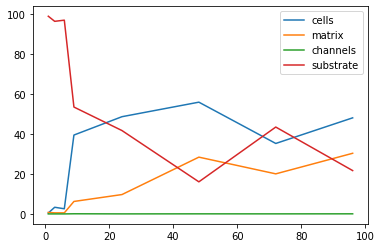

In [19]:
plt.plot(times, cells, label='cells')
plt.plot(times, matrix, label='matrix')
plt.plot(times, channels, label='channels')
plt.plot(times, substrate, label='substrate')
plt.legend()
plt.show()

Save results for the rate constants determination

In [20]:
df = pd.DataFrame({'C': cells,
                   'M': matrix,
                   'Ch': channels,
                   'S': substrate},
                  index=times)
df.index.name = 't'
df.to_csv(dirpath + 'ratio_calcs_results.csv')

This function allows visualization of segmentation maps

In [21]:
def check_image_results(time, number):
    if time==3:
        index = 1
    else:
        index = time
        
    image = cv2.imread(f'../data/advanced_biofilm_development_dynamics_images/D{time}/D{index}00{str(number).zfill(2)}.tif')
    
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10))
    
    fig.suptitle(f'Time: {time} h., Number: {number}', fontsize=25)
    ax1.set_title('Image')
    
    masked_image, mask_tensor = get_mask_tensor(seg_preds[f'D{time}_results.pkl'][number])
   
    
    ax1.imshow(image)
    
    ax2.set_title('Model Segmentation')
    ax2.imshow(masked_image)
    
    
    ax1.axis('off')    
    ax2.axis('off')
    plt.show()
    

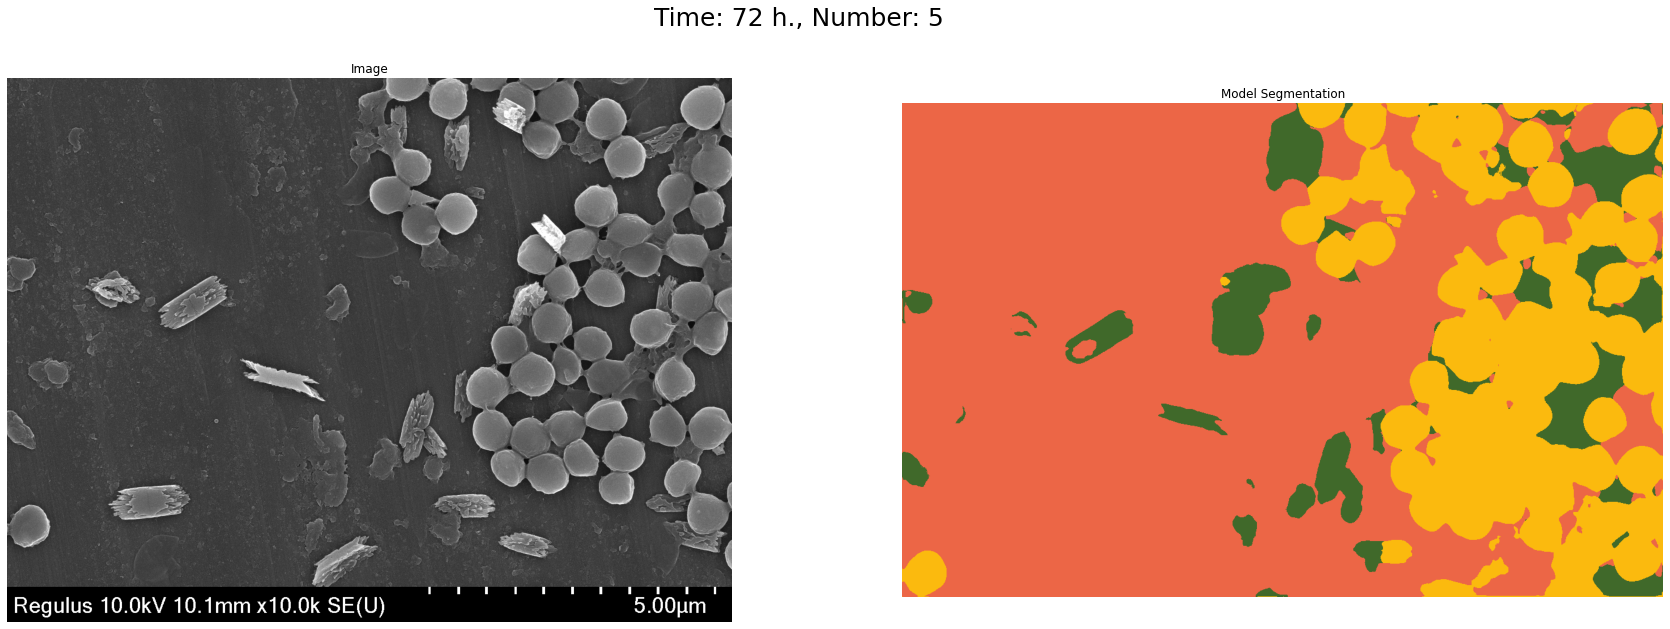

In [23]:
check_image_results(time=72, number=5)